In [1]:
from importlib.metadata import version
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import math
from dataclasses import dataclass
from matplotlib import pyplot as plt
import time
import os

# Pour torch si vous avez un GPU
# device = "cpu" if not torch.cuda.is_available() else "cuda"
device = "cpu" # Pour forcer l'utilisation du CPU


In [2]:
# Environement potentielement testé
from environnement.environnement import Environnement as env # mother class
from environnement.environnement1 import Environnement1 as env1
from environnement.environnement2Str import Environnement2 as env2Str
from environnement.environnement3Str import Environnement3 as env3Str
from environnement.environnement6Str import Environnement6 as env6Str
from environnement.small_loop import small_loop

# model machine learning
from model.deepNN import *
from model.Tokenizer import *
from outil import *
from inter.interactions import Interaction
from inter.simpleInteraction import simpleInteraction as inter



# L'agent qui choisit son destin
Dans se notebook nous reprennons la méthode de prédiciton de l'agent 1, mais cette fois l'action ne sera plus pris au hasard. Une fois que notre modèle est entrainer et arrive a correctement prédire le prochain feedback, l'agent poura prendre la meilleur action.

# Agent 2
Nous reprenons l'agent 1 et nous allons lui ajouter une fonction 'decide', qui permet de choisir la bonne action a faire en suivant une valence et les prédictions.

In [ ]:
class Agent2:
    def __init__(self, model, all_outcomes:list, all_actions:list,valance:dict[inter],
                tokenizer, optimizer=None, loss_func=None):
        """ 
        Création de l'agent.
        
        - self._action : action précédente
        - self._predicted_outcome : prédiction de l'outcome précédent
        """
        self._action = None
        self._predicted_outcome = None
        self._model = model
        self._otimizer = optimizer
        self._loss_func = loss_func
        self._tokenizer:SimpleTokenizerV1 = tokenizer
        self._all_outcomes = all_outcomes
        self._all_actions = all_actions
        self._valance=valance

    def fit(self, action, outcome, validate_loader=None):
        """
        Fonction d'entrainement de l'agent
        """
        action = self._tokenizer.encode(action)
        outcome = self._tokenizer.encode(outcome)
        try:
            self._model.train()
            action = torch.tensor([action], dtype=torch.float).to(device)
            outcome = torch.tensor(outcome, dtype=torch.long).to(device)
            outcome = torch.nn.functional.one_hot(outcome, 
                num_classes=len(self._all_outcomes)).to(torch.float)
            train(model=self._model, 
                    train_data=[(action, outcome)],
                    optimizer=self._otimizer,
                    loss_func=self._loss_func,
                    nb_epochs=10,
                    validate_loader=validate_loader,
                    print_=True)
        except Exception as e: # Si le model n'est pas un model pytorch
            raise Exception('Not implemented')
            self._model.fit(action, outcome)
            pass
       
    def predict(self, action):
        """
        Funciton de prédiction
        """
        action = self._tokenizer.encode(action)
        try: # Si le model est un model pytorch
            self._model.eval() # On peut le passer en mode evaluation
            # On prépare notre jeu de donnée, qui consite en 
            # la dernière action et l'outcome de la dernière interaction 
            action = torch.tensor([action], dtype=torch.float).to(device)
            x = self._model(action)
            x = torch.argmax(x, dim=0).item()

        except: # Si le model n'est pas un model pytorch
            raise Exception('Not implemented')
            x=self._model.predict(action)
        return self._tokenizer.decode(x)
    
    # Nouvelle fonction par rapport a l'agent 1
    def decide(self):
        """
        Fonction qui va choisir la meilleur action a faire, dépandament des prédictions du modèles entrainné.
        """
        best_act = self._all_actions[0]
        best_expected_val = -np.inf
        for act in self._all_actions:
            predi = self.predict(act)
            expected_val = self._valance[inter(act, predi)]
            if expected_val > best_expected_val:
                best_act = act
                best_expected_val = expected_val
        self._action = best_act
        return best_act

    def action(self, _outcome, fit=True, validate_loader=None):
        """ 
        Fonction qui choisit l'action a faire en fonction de la dernière \
        intéraction avec l'environnement. \n
        C'est ici que nous allons implémenter un mécanisme de ML \
        pour choisir la prochaine action.

        :param: **_outcome** feedback de la dernière intéraction avec l'environnement

        :return: **action** action à effectuer
        """
        if self._action is not None:
            print(f"Action: {self._action}, Prediction: {self._predicted_outcome}, Outcome: {_outcome}, " 
                  f"\033[0;31m Satisfaction: {self._predicted_outcome == _outcome} \033[0m")
            # Nous entrainons le model sur la dernière action et son outcome
            if fit:
                self.fit(self._action, _outcome, validate_loader)
            # Nous faisons une prédiction sur une action aléatoire
            self._action = self.decide()
            self._predicted_outcome = self.predict(self._action)
        else:
            # Au début de la vie de l'agent, nous prennons la première action possible
            self._action = self._all_actions[0]
            self._predicted_outcome = self.predict(self._action)
            print(f"Action de base : {self._action} aucune prédiciton pour la première action")
        
        return self._action, self._predicted_outcome

# Entrainement du modèle
Nous reprennons la deuxième méthode de l'agent 1 pour l'entrainement du modèl

liste hidden init [10, 5]
Epoch 1/20, Accuracy: 0.5
Epoch 2/20, Accuracy: 1.0
Epoch 3/20, Accuracy: 0.5
Epoch 4/20, Accuracy: 1.0
Epoch 5/20, Accuracy: 0.5
Epoch 6/20, Accuracy: 0.5
Epoch 7/20, Accuracy: 1.0
Epoch 8/20, Accuracy: 1.0
Epoch 9/20, Accuracy: 1.0
Epoch 10/20, Accuracy: 1.0
Epoch 11/20, Accuracy: 1.0
Epoch 12/20, Accuracy: 1.0
Epoch 13/20, Accuracy: 1.0
Epoch 14/20, Accuracy: 1.0
Epoch 15/20, Accuracy: 1.0
Epoch 16/20, Accuracy: 1.0
Epoch 17/20, Accuracy: 1.0
Epoch 18/20, Accuracy: 1.0
Epoch 19/20, Accuracy: 1.0
Epoch 20/20, Accuracy: 1.0


/tmp/ipykernel_14182/2599023353.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float).to(device)
/tmp/ipykernel_14182/2599023353.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


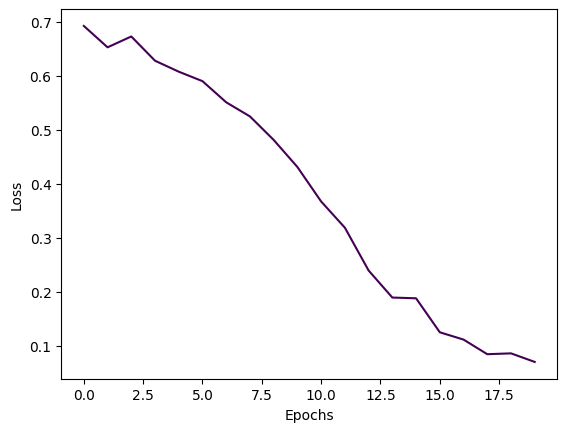

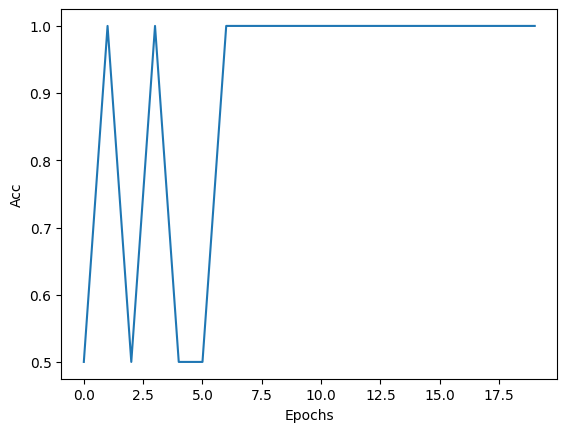

In [9]:
env_test2 = env1()
model_ML = DeepNetwork(hidden_size=[10, 5], input_size=1, output_size=2)
optimizer = torch.optim.Adam(model_ML.parameters(), lr=1e-1, weight_decay=1e-2)
loss_func = nn.CrossEntropyLoss()
tokenizer = SimpleTokenizerV1(
    create_dico_numerate_word(env_test2.get_outcomes() + env_test2.get_actions()))

x_train = [['a'], ['b']]
x_train = [tokenizer.encode(x) for x in x_train]
y_train = ['x', 'y']
y_train = tokenizer.encode(y_train)

x_train = torch.tensor(x_train, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.int64).to(device)
x_test = x_train
y_test = y_train

# Transforme y_fit en one hot
# Comme vue précédament, notre sortie est un vecteur qui donne des probabilié
# pour chaque dimension. Nous devons donc associé un vecteur a chaque outcome.
# Exemple :
# outcome = x
# encode('x') = 1
# one hot(1) = 01
# 
# outcome = y
# encode('y') = 0
# one hot(0) = 10
y_train = torch.nn.functional.one_hot(
    y_train, len(env_test2.get_outcomes())).to(torch.float)

x_test = torch.tensor(x_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train, y_train),
    batch_size=32, shuffle=True
)

validate_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test, y_test),
    batch_size=32, shuffle=False
)

bast_acc, best_model, all_acc, all_loss = train_with_batch(model=model_ML,
                train_loader=data_loader,
                validate_loader=validate_loader,
                optimizer=optimizer,
                loss_func=loss_func,
                nb_epochs=20,
                print_=True
            )
see_evolued_loss([all_loss])
see_evolued_acc(all_acc)

In [20]:
valence = {
    inter('a', 'x') : -1,
    inter('a', 'y') : 1,
    inter('b', 'x') : -1,
    inter('b', 'y') : 1
}
agent_test2 = Agent2(
    model=model_ML,
    all_outcomes= env_test2.get_outcomes(),
    all_actions= env_test2.get_actions(),
    valance=valence,
    tokenizer=tokenizer,
    optimizer=None,
    loss_func=None)

history_good = []
pourcent_by_10 = []
outcome = None
for i in range(20):
    print(f"=======================\033[0;32m iteration {i} \033[0m=======================")
    action, predi = agent_test2.action(outcome, False)
    outcome = env_test2.outcome(action)
    history_good.append(outcome == predi)
    pourcent_by_10.append(sum(history_good[-10:]) * 10 if len(history_good) >= 10 else 0)
    print(f'action {action} predi {predi} outcome {outcome}')
    print(f"Action choisie : {action} \033[0;34m{pourcent_by_10[-1]} \033[0m")
    time.sleep(1)
    print("\n\n")
    

======================= iteration 0 =======================
Action de base : a aucune prédiciton pour la première action
action a predi x outcome x
Action choisie : a 0 



======================= iteration 1 =======================
Action: a, Prediction: x, Outcome: x,  Satisfaction: True 
coucou
Pour l'action a nous avons une valance de -1
Pour l'action b nous avons une valance de 1
plus coucou
action b predi y outcome y
Action choisie : b 0 



======================= iteration 2 =======================
Action: b, Prediction: y, Outcome: y,  Satisfaction: True 
coucou
Pour l'action a nous avons une valance de -1
Pour l'action b nous avons une valance de 1
plus coucou
action b predi y outcome y
Action choisie : b 0 



======================= iteration 3 =======================
Action: b, Prediction: y, Outcome: y,  Satisfaction: True 
coucou
Pour l'action a nous avons une valance de -1
Pour l'action b nous avons une valance de 1
plus coucou
action b predi y outcome y
Action choisie 